
# Super-Resolution Evaluation — Mejiro LR → Diffusion HR

This notebook evaluates a trained diffusion model that upsamples **Mejiro** low‑resolution (Roman WFI–like) images into high‑resolution predictions.

**Assumptions** (already satisfied in your environment):
- `ema_model`: EMA-wrapped diffusion NN (PyTorch `nn.Module`)
- `sample_epsilon_conditional(model, x_cond=...)`: sampling function that returns HR predictions given LR inputs
- `test_loader`: PyTorch `DataLoader` yielding `(high_res, low_res)` batches shaped `[B, 1, H, W]` in `[-1, 1]`
- `DEVICE`: `'cuda'` or `'cpu'`

The metrics are computed purely in PyTorch (no extra deps): **PSNR**, **SSIM**, and **MS‑SSIM**.


In [1]:

import math
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from model_grav import *

# Ensure your model and loader are in scope:
# ema_model, sample_epsilon_conditional, test_loader, DEVICE
# assert 'ema_model' in globals(), "Please define `ema_model` in this kernel."
# assert 'sample_epsilon_conditional' in globals(), "Please define `sample_epsilon_conditional` in this kernel."
# assert 'test_loader' in globals(), "Please define `test_loader` in this kernel."
# assert 'DEVICE' in globals(), "Please define `DEVICE` (e.g., 'cuda')."

# Small helper for clean plotting range
model = UNet_512_mix_attn_conditional(use_cond_pyr=True, use_global_cond=True).to(DEVICE)

ema_model = copy.deepcopy(model).to(DEVICE)
for param in ema_model.parameters():
    param.requires_grad = False


In [2]:
from dataloaders import *

full_ds = PairsDatasetUnified(
    root_dir=".",
    norm_preset="minmax",
    out_range="[-1,1]",
    pad_to=48,
    noise_aug=None,               # skip extra noise
    return_order="HRLR"
)

n_total = len(full_ds)
n_train = int(0.9 * n_total)
train_ds, test_ds = random_split(full_ds, [n_train, n_total - n_train],
                                 generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Total: {n_total}, Train: {len(train_ds)}, Test: {len(test_ds)}")

Total: 20000, Train: 18000, Test: 2000


In [3]:
# model.load_state_dict(torch.load(r"grav_model_200_res_imp_mejiro_lsst.pt"), strict = False)    
# ema_model.load_state_dict(torch.load(r"grav_ema_model_200_res_imp_mejiro_lsst.pt"), strict=False)

model.load_state_dict(torch.load(r"grav_model_200_res_imp_mejiro_lsst_pyr_glob.pt"), strict = False)    
ema_model.load_state_dict(torch.load(r"grav_ema_model_200_res_imp_mejiro_lsst_pyr_glob.pt"), strict=False)

<All keys matched successfully>

## Quick sanity-check visualization

/tmp/user/1015/ipykernel_2513924/1283954906.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


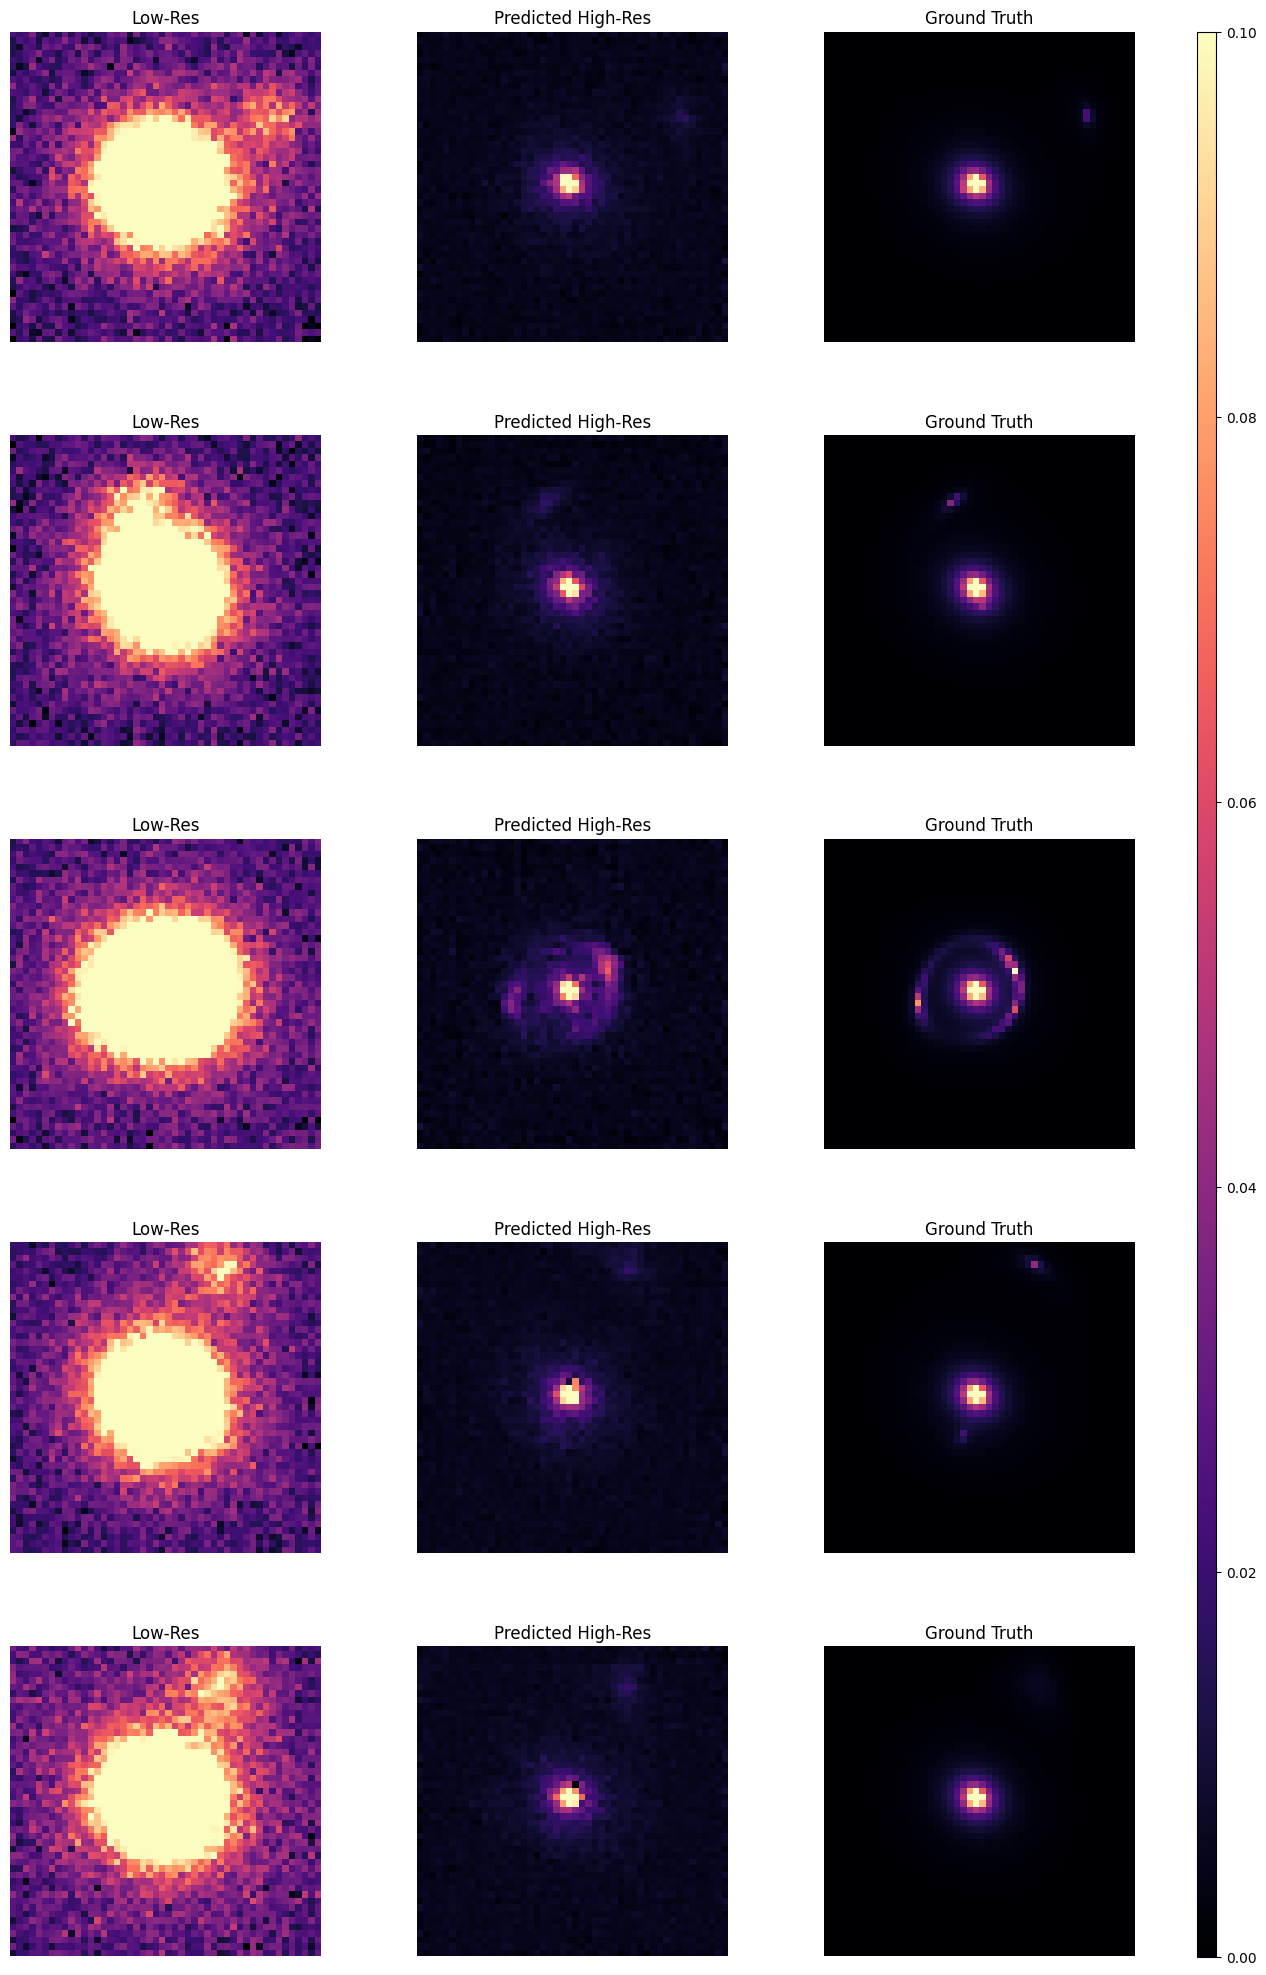

In [4]:

# Number of samples to visualize
vmax = 0.1
num_rows = 5
n_samples = num_rows

# --- Get a batch from the test loader ---
(high_res_batch, low_res_batch) = next(iter(test_loader))
high_res_batch = high_res_batch[:n_samples].to(DEVICE)
low_res_batch = low_res_batch[:n_samples].to(DEVICE)

# --- Generate model predictions ---
with torch.no_grad():
    ema_model.eval()
    preds = sample_epsilon_conditional(ema_model, x_cond=low_res_batch).cpu()

# Move inputs and labels to CPU and map to [0,1]
low_res_batch = (low_res_batch.cpu()+1)/2
high_res_batch = (high_res_batch.cpu()+1)/2

# --- Plotting ---
fig = plt.figure(figsize=(16, num_rows * 5))
gs = gridspec.GridSpec(num_rows, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.1, hspace=0.3)

for i in range(n_samples):
    # Low-res input
    ax1 = plt.subplot(gs[i, 0])
    ax1.imshow(low_res_batch[i, 0], cmap='magma', vmax=vmax)
    ax1.set_title("Low-Res")
    ax1.axis('off')

    # Model output
    ax2 = plt.subplot(gs[i, 1])
    ax2.imshow(preds[i, 0], cmap='magma', vmax=vmax)
    ax2.set_title("Predicted High-Res")
    ax2.axis('off')

    # Ground truth
    ax3 = plt.subplot(gs[i, 2])
    im3 = ax3.imshow(high_res_batch[i, 0], cmap='magma', vmax=vmax)
    ax3.set_title("Ground Truth")
    ax3.axis('off')

cbar_ax = plt.subplot(gs[:, 3])
plt.colorbar(im3, cax=cbar_ax)

plt.tight_layout()
plt.show()


## Metrics: PSNR, SSIM, and MS-SSIM (Torch-native)

In [5]:

from typing import Tuple

@torch.no_grad()
def psnr_torch(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-10) -> torch.Tensor:
    """pred, target in [0,1], shape [B,1,H,W] -> [B]"""
    mse = F.mse_loss(pred, target, reduction='none').mean(dim=[1,2,3])  # [B]
    psnr = -10.0 * torch.log10(mse + eps)
    return psnr  # [B]

def _gaussian_window(window_size: int = 11, sigma: float = 1.5, device='cpu', dtype=torch.float32) -> torch.Tensor:
    coords = torch.arange(window_size, dtype=dtype, device=device) - window_size // 2
    g = torch.exp(-(coords**2) / (2 * sigma * sigma))
    g = (g / g.sum()).unsqueeze(0)  # [1, W]
    window = (g.t() @ g)           # [W, W]
    return window

def _ssim_components(x, y, window, K=(0.01, 0.03)):
    """x,y in [0,1], shape [B,1,H,W], window [W,W] normalized."""
    C1 = (K[0] ** 2)
    C2 = (K[1] ** 2)
    pad = window.shape[0] // 2
    w = window.expand(x.size(1), 1, *window.shape).to(x.dtype).to(x.device)  # [C,1,W,W]

    mu_x = F.conv2d(x, w, padding=pad, groups=x.size(1))
    mu_y = F.conv2d(y, w, padding=pad, groups=y.size(1))
    mu_x2, mu_y2, mu_xy = mu_x * mu_x, mu_y * mu_y, mu_x * mu_y

    sigma_x2 = F.conv2d(x * x, w, padding=pad, groups=x.size(1)) - mu_x2
    sigma_y2 = F.conv2d(y * y, w, padding=pad, groups=y.size(1)) - mu_y2
    sigma_xy = F.conv2d(x * y, w, padding=pad, groups=x.size(1)) - mu_xy

    # Luminance, contrast, structure terms
    l = (2 * mu_xy + C1) / (mu_x2 + mu_y2 + C1)
    c = (2 * torch.sqrt(torch.clamp(sigma_x2, min=0)) * torch.sqrt(torch.clamp(sigma_y2, min=0)) + C2) /         (sigma_x2 + sigma_y2 + C2)
    s = (sigma_xy + C2 / 2) / (torch.sqrt(torch.clamp(sigma_x2, min=0)) * torch.sqrt(torch.clamp(sigma_y2, min=0)) + C2 / 2 + 1e-12)
    return l, c, s  # each [B,1,H,W]

@torch.no_grad()
def ssim_torch(pred: torch.Tensor, target: torch.Tensor, window_size: int = 11, sigma: float = 1.5) -> torch.Tensor:
    """Single-scale SSIM. Returns per-sample SSIM [B]."""
    window = _gaussian_window(window_size, sigma, device=pred.device, dtype=pred.dtype)
    l, c, s = _ssim_components(pred, target, window)
    ssim_map = l * c * s
    return ssim_map.mean(dim=[1,2,3])

@torch.no_grad()
def msssim_torch(pred: torch.Tensor, target: torch.Tensor, window_size: int = 11, sigma: float = 1.5, levels: int = 5) -> torch.Tensor:
    """Multi-scale SSIM (Wang et al. 2003) with standard weights for 5 levels."""
    weights = torch.tensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333], device=pred.device, dtype=pred.dtype)
    weights = weights[:levels]
    window = _gaussian_window(window_size, sigma, device=pred.device, dtype=pred.dtype)

    mcs = []
    x, y = pred, target
    for i in range(levels):
        l, c, s = _ssim_components(x, y, window)
        if i < levels - 1:
            mcs.append(c * s)  # contrast*structure for intermediate scales
            x = F.avg_pool2d(x, kernel_size=2, stride=2, padding=0)
            y = F.avg_pool2d(y, kernel_size=2, stride=2, padding=0)
        else:
            ms_ssim_map = l * c * s

    mcs = torch.stack([mc.mean(dim=[1,2,3]) for mc in mcs], dim=1) if len(mcs) else torch.ones(pred.size(0), 0, device=pred.device, dtype=pred.dtype)
    s_l = ms_ssim_map.mean(dim=[1,2,3])  # [B]
    if mcs.numel() > 0:
        out = torch.prod(mcs ** weights[:-1], dim=1) * (s_l ** weights[-1])
    else:
        out = s_l
    return out  # [B]


def mae(pred, target):
    """Mean Absolute Error"""
    return F.l1_loss(pred, target).item()

def mse(pred, target):
    """Mean Squared Error"""
    return F.mse_loss(pred, target).item()



## Batched evaluation over ~1000 samples

In [8]:

@torch.no_grad()
def evaluate_sr(
    ema_model,
    sample_epsilon_conditional,
    test_loader,
    DEVICE='cuda',
    MAX_SAMPLES: int = 1000,
):
    ema_model.eval()
    n_done = 0
    psnr_sum = 0.0
    ssim_sum = 0.0
    msssim_sum = 0.0
    mae_sum = 0.0
    mse_sum = 0.0

    for batch in test_loader:
        high_res_batch, low_res_batch = batch

        if n_done >= MAX_SAMPLES:
            break
        remain = MAX_SAMPLES - n_done
        if high_res_batch.size(0) > remain:
            high_res_batch = high_res_batch[:remain]
            low_res_batch = low_res_batch[:remain]

        high_res_batch = high_res_batch.to(DEVICE)
        low_res_batch = low_res_batch.to(DEVICE)

        preds = sample_epsilon_conditional(ema_model, x_cond=low_res_batch)

        # Map to [0,1]
        preds = preds.clamp(0.0, 1.0)               # predicted HR
        high_res_batch = (high_res_batch + 1) / 2.0 # GT HR

        # Ensure [B,1,H,W]
        if preds.dim() == 3:
            preds = preds.unsqueeze(1)
        if high_res_batch.dim() == 3:
            high_res_batch = high_res_batch.unsqueeze(1)

        # Per-image metrics (assume psnr_torch/ssim_torch/msssim_torch -> [B])
        psnr_vals   = psnr_torch(preds, high_res_batch)     # [B]
        ssim_vals   = ssim_torch(preds, high_res_batch)     # [B]
        msssim_vals = msssim_torch(preds, high_res_batch)   # [B]

        # MAE/MSE per image: reduce over pixels per sample, then mean over batch
        # reduction='none' -> [B,1,H,W] -> collapse spatial dims per sample
        mae_vals = F.l1_loss(preds, high_res_batch, reduction='none') \
                     .view(preds.size(0), -1).mean(dim=1)            # [B]
        mse_vals = F.mse_loss(preds, high_res_batch, reduction='none') \
                     .view(preds.size(0), -1).mean(dim=1)            # [B]

        psnr_sum   += psnr_vals.sum().item()
        ssim_sum   += ssim_vals.sum().item()
        msssim_sum += msssim_vals.sum().item()
        mae_sum    += mae_vals.sum().item()
        mse_sum    += mse_vals.sum().item()
        n_done     += preds.size(0)

        # live progress
        if n_done % 100 == 0 or n_done == MAX_SAMPLES:
            print(f"[eval] {n_done}/{MAX_SAMPLES} — "
                  f"PSNR: {psnr_sum/n_done:.3f}  "
                  f"SSIM: {ssim_sum/n_done:.4f}  "
                  f"MS-SSIM: {msssim_sum/n_done:.4f}  "
                  f"MAE: {mae_sum/n_done:.6f}  "
                  f"MSE: {mse_sum/n_done:.6f}")

        if n_done >= MAX_SAMPLES:
            break

    psnr_avg    = psnr_sum / n_done
    ssim_avg    = ssim_sum / n_done
    msssim_avg  = msssim_sum / n_done
    mae_avg     = mae_sum / n_done
    mse_avg     = mse_sum / n_done
    print(f"\nFINAL ({n_done} images) — "
          f"PSNR: {psnr_avg:.3f}  SSIM: {ssim_avg:.4f}  MS-SSIM: {msssim_avg:.4f}  "
          f"MAE: {mae_avg:.12f}  MSE: {mse_avg:.12f}")
    return psnr_avg, ssim_avg, msssim_avg, mae_avg, mse_avg


In [9]:
psnr_avg, ssim_avg, msssim_avg, mae_avg, mse_avg = evaluate_sr(
    ema_model=ema_model,
    sample_epsilon_conditional=sample_epsilon_conditional,
    test_loader=test_loader,
    DEVICE=DEVICE,
    MAX_SAMPLES=1000,
)


[eval] 1000/1000 — PSNR: 53.625  SSIM: 0.9946  MS-SSIM: 0.9995  MAE: 0.001060  MSE: 0.000006

FINAL (1000 images) — PSNR: 53.625  SSIM: 0.9946  MS-SSIM: 0.9995  MAE: 0.001059687227  MSE: 0.000005567043


### (Optional) Save per-image metrics to CSV

In [ ]:

# If you need per-image metrics (not just averages), run this cell.
import pandas as pd

@torch.no_grad()
def evaluate_sr_per_image(
    ema_model,
    sample_epsilon_conditional,
    test_loader,
    DEVICE='cuda',
    MAX_SAMPLES: int = 1000,
):
    ema_model.eval()
    rows = []
    n_done = 0
    for batch_idx, batch in enumerate(test_loader):
        high_res_batch, low_res_batch = batch
        if n_done >= MAX_SAMPLES:
            break
        remain = MAX_SAMPLES - n_done
        if high_res_batch.size(0) > remain:
            high_res_batch = high_res_batch[:remain]
            low_res_batch = low_res_batch[:remain]

        high_res_batch = high_res_batch.to(DEVICE)
        low_res_batch = low_res_batch.to(DEVICE)

        preds = sample_epsilon_conditional(ema_model, x_cond=low_res_batch)
        preds = preds.clamp(0.0, 1.0)
        high_res_batch = (high_res_batch + 1) / 2.0

        if preds.dim() == 3:
            preds = preds.unsqueeze(1)
        if high_res_batch.dim() == 3:
            high_res_batch = high_res_batch.unsqueeze(1)

        psnr_vals   = psnr_torch(preds, high_res_batch).cpu().numpy()
        ssim_vals   = ssim_torch(preds, high_res_batch).cpu().numpy()
        msssim_vals = msssim_torch(preds, high_res_batch).cpu().numpy()

        for i in range(preds.size(0)):
            rows.append({
                "index_global": n_done + i,
                "batch": batch_idx,
                "index_in_batch": i,
                "psnr": float(psnr_vals[i]),
                "ssim": float(ssim_vals[i]),
                "ms_ssim": float(msssim_vals[i])
            })
        n_done += preds.size(0)

    df = pd.DataFrame(rows)
    return df

df_metrics = evaluate_sr_per_image(
    ema_model=ema_model,
    sample_epsilon_conditional=sample_epsilon_conditional,
    test_loader=test_loader,
    DEVICE=DEVICE,
    MAX_SAMPLES=1000,
)
csv_path = "/mnt/data/sr_metrics_per_image.csv"
df_metrics.to_csv(csv_path, index=False)
print("Saved:", csv_path)
